# fNIRS to fMRI
In this notebook, we develop a pipeline for turning fMRI data into pseudo-fNIRS data, and we apply it to the NSD.

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Install Libraries

In [45]:
## uncomment if FSL library not installed
# !sudo apt -qq install file
# !wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fslinstaller.py
# !python3 fslinstaller.py

from pathlib import Path
fslpath = Path(os.getcwd()).parents[1].as_posix()+'/fsl'
os.environ["FSLDIR"] = fslpath
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, 'bin')
!. ${FSLDIR}/etc/fslconf/fsl.sh

## Pipeline

In [46]:
from subject import Subject

# define subject (id: '01' to '08') and create segmentation
subj = Subject(id='01')

In [47]:
# place optodes and visualize in anatomical space
subj.place_optodes(nsources=10, ndetectors=100)
# subj.display_setup()

/home/rhotter/.local/share/virtualenvs/tomography-experiments-nAi89yU4/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Probes placed... Bringing toward center in by 3%


/home/rhotter/.local/share/virtualenvs/tomography-experiments-nAi89yU4/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Probes placed... Bringing toward center in by 3%


In [48]:
# transform anatomical segmentation into a given session (id: '21' to '30') and run (id: '01' to '12')
seg_transformed, geom_transformed = subj.transform(sessionID='21', runID='01')
subj.display_setup(seg_transformed, geom_transformed)

Saved to test.json


Now that we've placed the optodes, it's good to do a sanity check. View 3D optode placement in browser gui by:
- In this directory go to `sanity_optode_placement.json`, entire file contents to clipboard (e.g. ctrl-a ctrl-c)
- Open [MCX cloud](https://mcx.space/cloud/) in browser
- Click JSON, delete the contents of that JSON file, replace it with your clip-board 
- Click Preview to view optode placement

# Forward solve

INPUT: 3D head mask is found in `data/subID/func/fmri/sessID/runID` 

OUTPUT: Measurement data in `data/subID/func/fnirs/sessID/runID`

In [49]:
import pmcx

In [50]:
# TODO: properties might need revision
media_properties = [
    [0,       0,       1.0000,  1.0000], # background/air (not air pockets!)
    [0.0190,  7.8182,  0.8900,  1.3700], # scalp/skull
    [0.0040,  0.0090,  0.8900,  1.3700], # csf
    [0.0200,  9.0000,  0.8900,  1.3700], # gray matters
    [0.0800,  40.9000, 0.8400,  1.3700]] # white matters

# prop = [[0,0,1,1],[0,0,g,n]]

n = 1.37 # index of refraction
g = 0.9 # anisotropy factor

i = 0

cfg = {
       'nphoton': 1000000,
       'vol': seg_transformed,
       'tstart':0,
       'tend': 5e-9,
       'tstep': 1e-10,
       'srcpos': geom_transformed.sources[i],
       'srcdir': geom_transformed.directions[i],
       'detpos': geom_transformed.detectors,
       'prop': media_properties,
       'issavedet': 1,
       'issavedetphoton' : 1,
    #    'issrcfrom0': 1,
    #    'maxdetphoton': 1000000000,
       }

In [51]:
res = pmcx.run(cfg)

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09


srcpos: [40.4129, 21.0285, 68.2999, 1]
srcdir: [0.474957, 0.592242, -0.650895, 0]
issavedet: 1
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed h

In [ ]:
res['']

/tmp/ipykernel_278091/3817000775.py:1: RuntimeWarning:

divide by zero encountered in log10



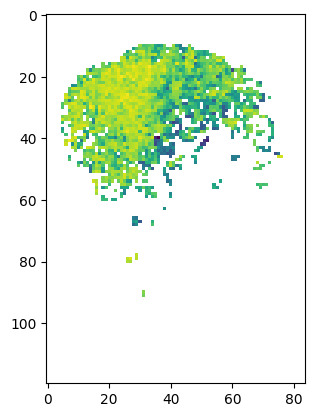

In [13]:
plt.imshow(np.log10(res['flux'][40,:,:,20]))
plt.show()

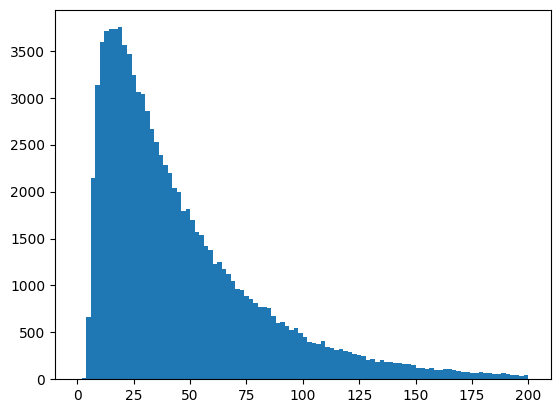

In [14]:
plt.hist(res['detp'][1], bins=100, range=[0,200])
plt.show()

In [23]:
import matplotlib.animation as animation

/tmp/ipykernel_277404/3672644514.py:7: RuntimeWarning:

divide by zero encountered in log10

/tmp/ipykernel_277404/3672644514.py:11: RuntimeWarning:

divide by zero encountered in log10

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_277404/3672644514.py:11: RuntimeWarning:

divide by zero encountered in log10



ValueError: unknown file extension: .mp4

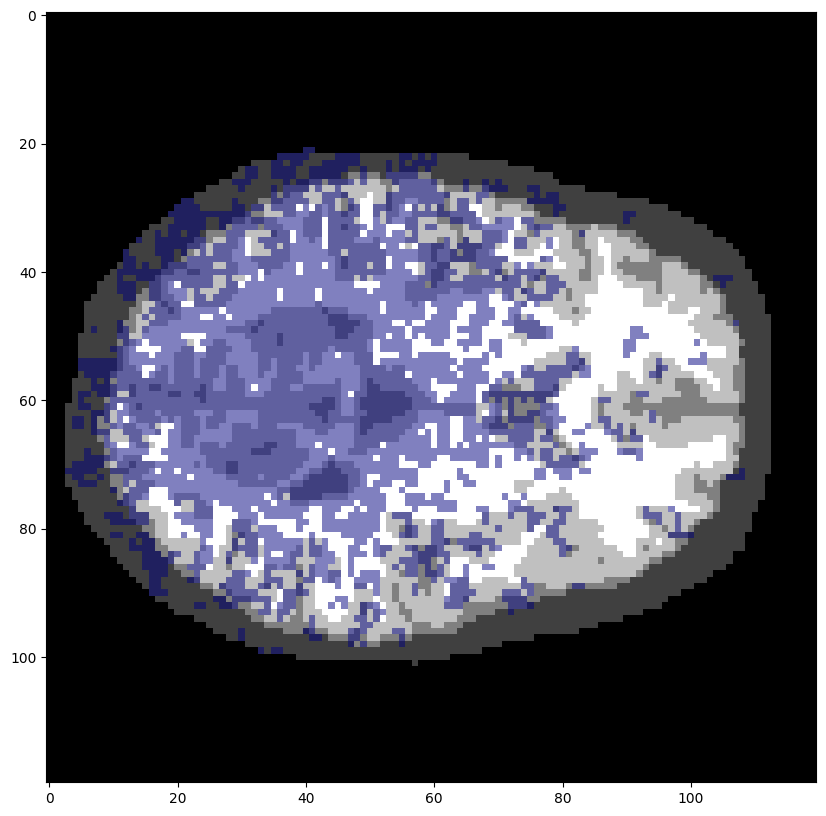

In [24]:
# Set up the figure
zidx = seg_transformed.shape[2] // 2
fig, ax = plt.subplots(figsize=(10, 10))

# Initial frame
im1 = ax.imshow(seg_transformed[:,:,zidx], animated=True, cmap='gray')
im2 = ax.imshow(np.log10(res['flux'][:,:,zidx, 0]), animated=True, alpha=0.5, cmap='jet')

# Update function
def update(t):
    im2.set_array(np.log10(res['flux'][:,:,zidx, t]))
    return im2,

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=res['flux'].shape[3], blit=True)

# Save the animation
ani.save('visualization.mp4', writer='ffmpeg', fps=5)

plt.close(fig)

In [52]:
import nibabel as nib
fmri = nib.load('data/sub01/func/fmri/sess21/run01/sub-01_ses-nsd21_task-nsdcore_run-01_bold.nii.gz').get_fdata()

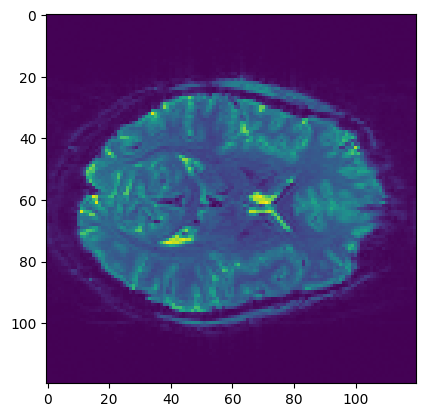

In [53]:
plt.imshow(fmri[:,:,42,0]); plt.show()

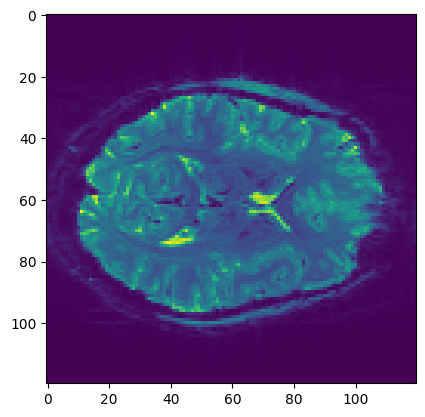

In [54]:
fmri_avg = np.average(fmri, axis=3)
plt.imshow(fmri_avg[:,:,42]); plt.show()

In [55]:
bold_percent = 1 + (fmri - fmri_avg[:,:,:,np.newaxis]) / fmri_avg[:,:,:,np.newaxis]

/tmp/ipykernel_276234/1690384054.py:1: RuntimeWarning:

invalid value encountered in divide



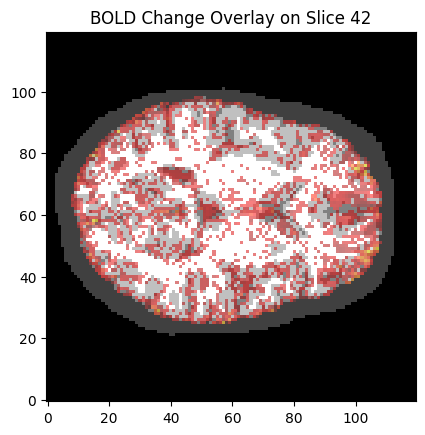

In [92]:
def plot_bold(anat_seg, bold, slice=42):
    """
    anat_seg: segmented T1 image (nx, ny, nz) in a numpy array
    bold: bold percent change (nx, ny, nz) in a numpy array, e.g. 1 = no change
    slice: index of the slice along the z-axis
    """
    
    # Validate input dimensions
    if anat_seg.shape != bold.shape:
        raise ValueError("The shapes of anat_seg and bold must be the same")
    
    if slice < 0 or slice >= anat_seg.shape[2]:
        raise ValueError("Invalid slice index")
    
    # Extract the slice from the 3D images
    anat_slice = anat_seg[:,:,slice]
    bold_slice = bold[:,:,slice]

    # mask pixels where there's no brain
    bold_slice = np.ma.masked_where(anat_slice < 2, bold_slice)

    
    # Mask for pixels where there's a change in the BOLD signal
    mask = np.abs(bold_slice - 1) > 0.05

    
    # Create the plot
    fig, ax = plt.subplots()
    
    # Show the anatomical slice
    ax.imshow(anat_slice, cmap='gray', origin='lower')
    
    # Overlay the BOLD percent change where it differs from 1
    ax.imshow(np.ma.masked_where(~mask, bold_slice-1), cmap='hot', alpha=0.5, origin='lower')
    
    ax.set_title(f"BOLD Change Overlay on Slice {slice}")
    
    # add colorbar for bold

    plt.show()

plot_bold(seg_transformed, bold_percent[...,0])

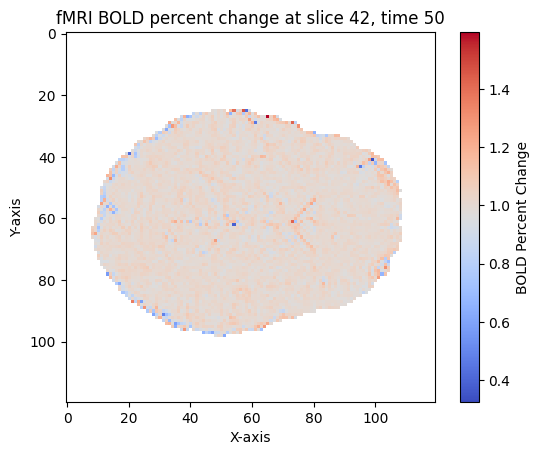

In [75]:
def plot_bold_percent(t, z=42):
    masked_array = np.ma.masked_where(seg_transformed[:,:,z] < 2, bold_percent[:,:,z,t])
    # masked_array = np.clip(masked_array, 0.8, 1.2)
    plt.imshow(masked_array, cmap='coolwarm')
    plt.colorbar(label='BOLD Percent Change')
    plt.title(f'fMRI BOLD percent change at slice {z}, time {t}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
plot_bold_percent(50)

In [57]:
def bold2optical(bold_change, seg_transformed):
    
    # 1. build baseline optical properties
    # optical_baseline should be of shape (2, x,y,z)
    newshape = (2, *seg_transformed.shape)
    optical_baseline = np.zeros(newshape)
    for idx, prop in enumerate(media_properties):
        # when seg_transformed == idx, optical_baseline[0] == prop[0], optical_baseline[1] == prop[1]
        optical_baseline[0][seg_transformed == idx] = prop[0] # mu_a
        optical_baseline[1][seg_transformed == idx] = prop[1] # mu_s
    

    # 2. build optical properties change
    optical_change = (bold_change - 1) * 0.20 + 1 # scientific scaling factor BOLD -> optical
    
    optical_vol = optical_baseline[..., np.newaxis]  # Adds a new axis along the last dimension

    # Now fill in the new dimension
    optical_vol = np.repeat(optical_vol, bold_change.shape[-1], axis=-1)
    print(optical_vol.shape)

    # print(optical_change.shape, seg_transformed.shape)
    for i in range(optical_vol.shape[-1]):
        optical_vol[0,:,:,:,i] *= optical_change[:,:,:,i] * (seg_transformed > 2) # white and grey matter
    
    # put back the removed properties 
    for i in [0,1,2]:
        optical_vol[0,:,:,:][seg_transformed == i] = media_properties[i][0]

    return optical_vol.astype(np.float32), optical_baseline.astype(np.float32)
optical_vol, optical_baseline = bold2optical(bold_percent, seg_transformed)



(2, 120, 120, 84, 188)


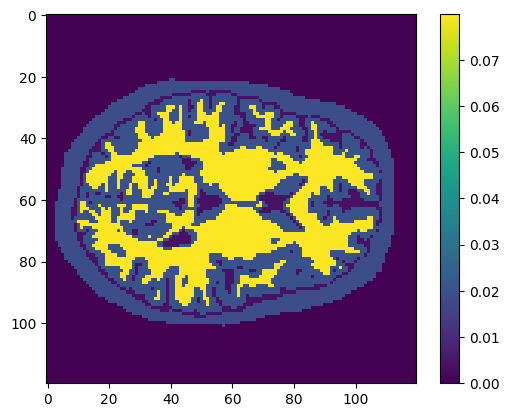

In [58]:
plt.imshow(optical_baseline[0,:,:,42]); plt.colorbar(); plt.show()

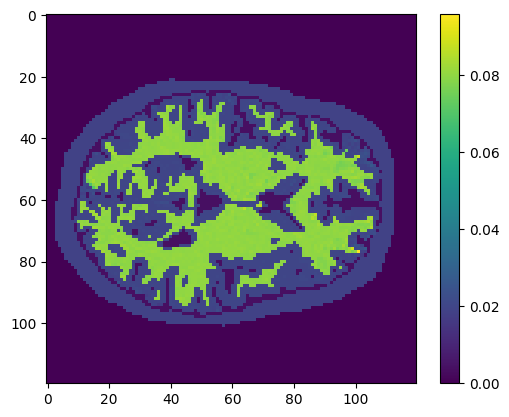

In [59]:
plt.imshow(optical_vol[0,:,:,42,2]); plt.colorbar(); plt.show()

In [68]:
n = 1.37 # index of refraction
g = 0.9 # anisotropy factor

i = 1

res = []
time_idx = 0
# for time_idx in range(optical_vol.shape[-1]):
cfg = {
       'nphoton': 1000000,
       'vol': optical_vol[..., time_idx],
       'tstart':0,
       'tend': 5e-9,
       'tstep': 1e-10,
       'srcpos': geom_transformed.sources[i],
       'srcdir': geom_transformed.directions[i],
       'detpos': geom_transformed.detectors,
       'prop': [
              [0,0,1,1],
              [0,0,g,n]
       ],
       'issavedet': 1,
       }
newresult = pmcx.run(cfg)
res.append(newresult)
print("time_idx", time_idx)
print()

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 5e-09
srcpos: [56.5608, 67.5958, 78.997, 1]
srcdir: [-0.000497722, -0.437673, -0.899134, 0]
issavedet: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse,#
#  Please consider using JSON (https://n

eurojson.org/) for your research data #
###############################################################################
$Rev::53e268$ v2023  $Date::2023-09-05 00:11:31 -04$ by $Author::Qianqian Fang$
###############################################################################
- code name: [Fermi MCX] compiled by nvcc [9.2] for CUDA-arch [350] on [Sep  5 2023]
- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (NVIDIA A100-SXM4-40GB) threadph=2 extra=115264 np=1000000 nthread=442368 maxgate=50 repetition=1
initializing streams ...	init complete : 2 ms
requesting 1024 bytes of shared memory
launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...
simulation run# 1 ... 
kernel complete:  	193 ms
retrieving fields ... 	detected 0 photons, total: 0	transfer complete:	401 ms
normalizing raw data ...	source 1, normalization factor alpha=10000.000000
data normalization complete : 1261 ms
simulated 1000000 photons (1000000) with 442368 threads (repeat x1)
MCX simulat

ed on an interface, please check coordinates.


In [74]:
res[0].keys()

dict_keys(['flux', 'stat'])